In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from shearnet.core.dataset import generate_dataset
from shearnet.core.train import train_model
from shearnet import EnhancedGalaxyNN
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import os

from flax.training import checkpoints, train_state
from shearnet.utils.metrics import eval_model, eval_ngmix, eval_mcal
from shearnet.utils.plot_helpers import (
    plot_residuals, 
    visualize_samples, 
    plot_true_vs_predicted, 
    animate_model_epochs
)

In [3]:
rng_key = random.PRNGKey(42)
test_images, test_labels, test_obs = generate_dataset(5000, 0.25, npix=53, scale=0.141, type='gauss', exp='ideal', seed=42, return_obs=True)

100%|██████████| 5000/5000 [00:06<00:00, 745.04it/s]


In [5]:
model = EnhancedGalaxyNN()
model_name = 'cnn1'
nn = 'cnn'

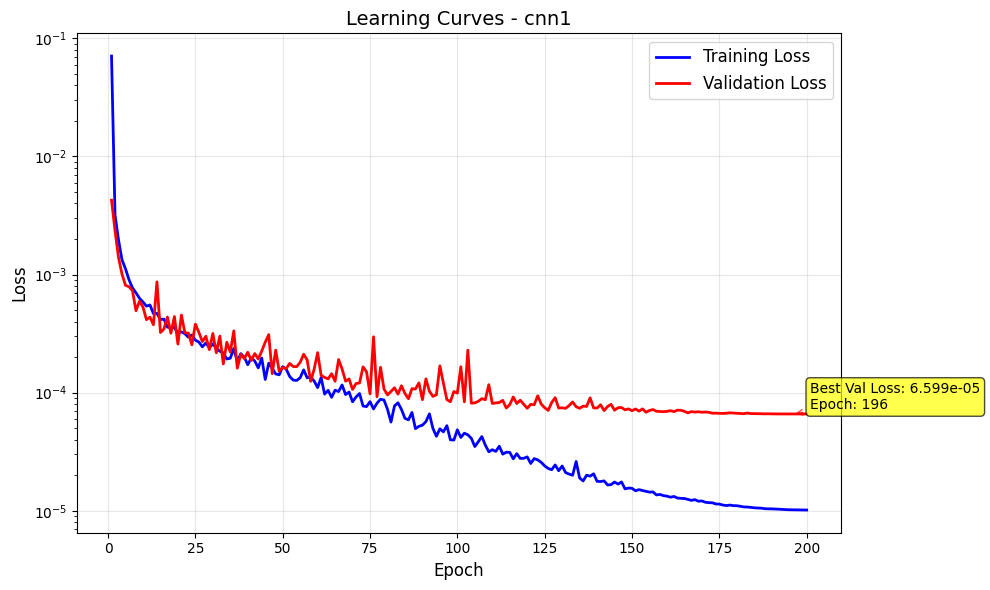

Final training loss: 0.000010
Final validation loss: 0.000066
Best validation loss: 0.000066 at epoch 196
Total epochs: 200


In [6]:
loss_file = os.path.join(os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.')), "plots", model_name, f"{model_name}_loss.npz")
loss = np.load(loss_file)

train_loss = loss['train_loss']
val_loss = loss['val_loss']

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation loss
epochs = np.arange(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.yscale("log")
# Add labels and title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Learning Curves - {model_name}', fontsize=14)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# If you want log scale on y-axis (useful if loss varies over orders of magnitude)
# plt.yscale('log')

# Add annotations for best validation loss
best_val_epoch = np.argmin(val_loss) + 1
best_val_loss = np.min(val_loss)
plt.annotate(f'Best Val Loss: {best_val_loss:.3e}\nEpoch: {best_val_epoch}',
             xy=(best_val_epoch, best_val_loss), 
             xytext=(best_val_epoch + 5, best_val_loss * 1.1),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

# Optional: Save the figure
# plt.savefig(os.path.join(os.path.dirname(loss_file), f"{model_name}_learning_curves.png"), dpi=300, bbox_inches='tight')

# Print some statistics
print(f"Final training loss: {train_loss[-1]:.6f}")
print(f"Final validation loss: {val_loss[-1]:.6f}") 
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_val_epoch}")
print(f"Total epochs: {len(train_loss)}")

In [7]:
init_params = model.init(rng_key, jnp.ones_like(test_images[0]))
state = train_state.TrainState.create(
        apply_fn=model.apply, params=init_params, tx=optax.adam(1e-3)
    )
load_path = os.path.join(os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.')), "model_checkpoint")
model_name = 'cnn1'
matching_dirs = [
        d for d in os.listdir(load_path) 
        if os.path.isdir(os.path.join(load_path, d)) and d.startswith(model_name)
    ]
print(f"Number of matching directories found: {len(matching_dirs)}")
for idx, directory in enumerate(matching_dirs, start=1):
    print(f"Matching directory {idx}: {directory}")

if matching_dirs:
    # If there's only one matching directory, use it
    if len(matching_dirs) == 1:
        model_dir = os.path.join(load_path, matching_dirs[0])
    else:
        # If multiple directories, you might want to choose the latest one
        # This assumes directory names include timestamps or are sortable
        model_dir = os.path.join(load_path, sorted(matching_dirs)[-1])

state = checkpoints.restore_checkpoint(ckpt_dir=model_dir, target=state)

nn_results = eval_model(state, test_images, test_labels)
ngmix_results = eval_ngmix(test_obs, test_labels, seed=1234)

Number of matching directories found: 1
Matching directory 1: cnn1200

=== Combined Metrics (ShearNet) ===
Mean Squared Error (MSE) from ShearNet: 2.494994e-05
Average Bias from ShearNet: -1.134294e-04
Time taken: 2.50 seconds

=== Per-Label Metrics ===
             g1: MSE = 1.306612e-05, Bias = -1.703652e-04
             g2: MSE = 1.484776e-05, Bias = +9.929320e-05
  g1g2_combined: MSE = 1.395694e-05, Bias = -3.553597e-05
          sigma: MSE = 1.944171e-05, Bias = -1.639236e-04
           flux: MSE = 5.244421e-05, Bias = -2.187221e-04

Starting NGmix ML fitting: num_gal: 5000 | psf_model: gauss | gal_model: gauss | num_cores: 128

=== Combined Metrics (NGmix) ===
Mean Squared Error (MSE) from NGmix: 3.570214e-03
Average Bias from NGmix: 2.079603e-02
Time taken: 425.61 seconds

=== Per-Label Metrics ===
             g1: MSE = 1.262880e-04, Bias = +2.865881e-04
             g2: MSE = 1.338599e-04, Bias = -4.320226e-04
  g1g2_combined: MSE = 1.300739e-04, Bias = -7.271726e-05
         

In [10]:
preds_ngmix = ngmix_results["preds"]
preds_nn = nn_results["all_preds"]

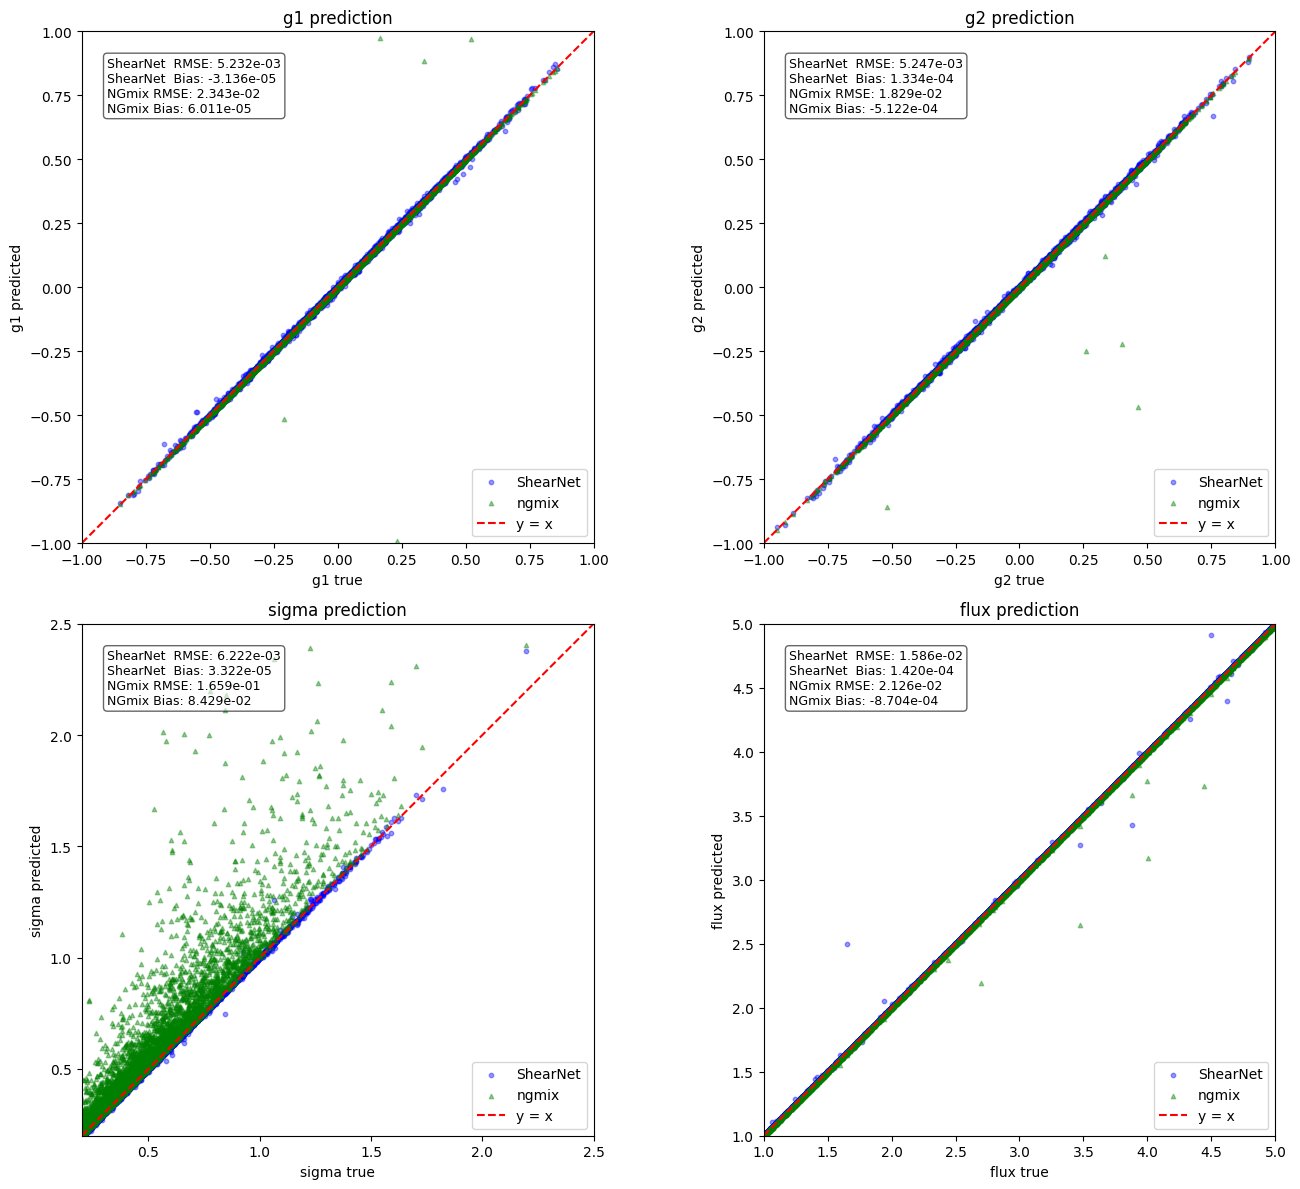

In [16]:
# True values
g1_true = test_labels[:, 0]
g2_true = test_labels[:, 1]
sigma_true = test_labels[:, 2]
flux_true = test_labels[:, 3]

# NN predictions
g1_nn = preds_nn[:, 0]
g2_nn = preds_nn[:, 1]
sigma_nn = preds_nn[:, 2]
flux_nn = preds_nn[:, 3]

# ngmix predictions
g1_ngmix = preds_ngmix[:, 0]
g2_ngmix = preds_ngmix[:, 1]
sigma_ngmix = preds_ngmix[:, 2]
flux_ngmix = preds_ngmix[:, 3]

# Set up plot
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

quantities = [
    ("g1", g1_true, g1_nn, g1_ngmix, -1., 1.),
    ("g2", g2_true, g2_nn, g2_ngmix, -1., 1.),
    ("sigma", sigma_true, sigma_nn, sigma_ngmix, 0.2, 2.5),
    ("flux", flux_true, flux_nn, flux_ngmix, 1, 5.)
]

for ax, (name, true, nn, ngmix, vmin, vmax) in zip(axs.flat, quantities):
    # Plot predictions
    ax.scatter(true, nn, alpha=0.4, label="ShearNet", s=10, color='blue', marker='o')
    ax.scatter(true, ngmix, alpha=0.4, label="ngmix", s=10, color='green', marker='^')
    
    # Reference line
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', label='y = x')
    
    # Axes formatting
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(f"{name} true")
    ax.set_ylabel(f"{name} predicted")
    ax.set_title(f"{name} prediction")

    # Optional: log scale for sigma or flux
    #if name in ["sigma", "flux"]:
    #    ax.set_xscale('log')
    #    ax.set_yscale('log')

    # Metrics
    rmse_nn = np.sqrt(np.mean((nn - true)**2))
    bias_nn = np.mean(nn - true)
    rmse_ngmix = np.sqrt(np.mean((ngmix - true)**2))
    bias_ngmix = np.mean(ngmix - true)

    ax.text(0.05, 0.95, 
            f"ShearNet  RMSE: {rmse_nn:.3e}\nShearNet  Bias: {bias_nn:.3e}\n"
            f"NGmix RMSE: {rmse_ngmix:.3e}\nNGmix Bias: {bias_ngmix:.3e}",
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

    ax.legend()

plt.tight_layout()
plt.show()


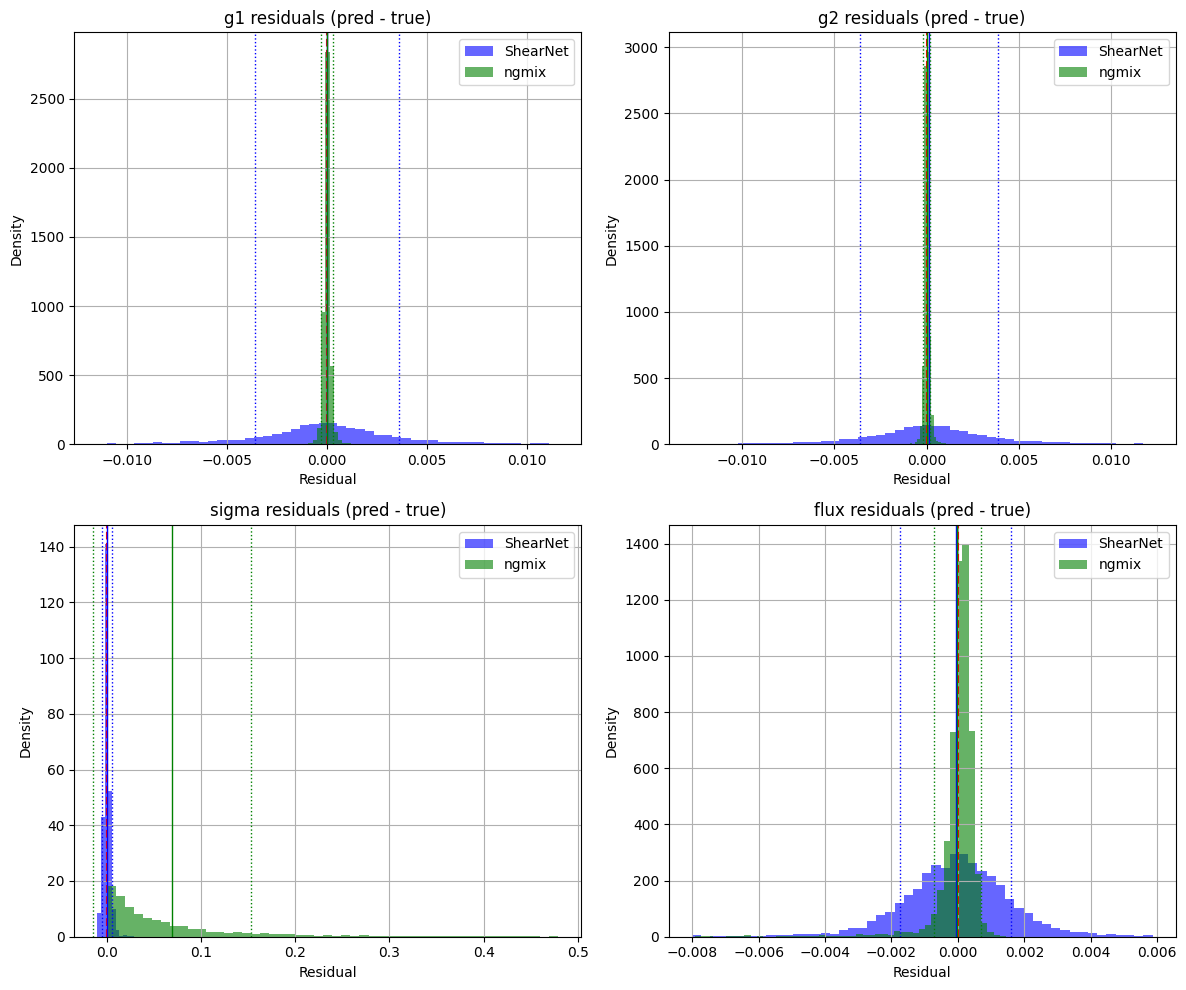

In [37]:
# Compute residuals
residuals = {
    "g1": (preds_nn[:, 0] - test_labels[:, 0], preds_ngmix[:, 0] - test_labels[:, 0]),
    "g2": (preds_nn[:, 1] - test_labels[:, 1], preds_ngmix[:, 1] - test_labels[:, 1]),
    "sigma": (preds_nn[:, 2] - test_labels[:, 2], preds_ngmix[:, 2] - test_labels[:, 2]),
    "flux": (preds_nn[:, 3] - test_labels[:, 3], preds_ngmix[:, 3] - test_labels[:, 3]),
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
bins = 50

for ax, (key, (res_nn, res_ngmix)) in zip(axs.flat, residuals.items()):
    # Clip extremes to focus on the bulk distribution
    clip_min = np.percentile(np.concatenate([res_nn, res_ngmix]), 1)
    clip_max = np.percentile(np.concatenate([res_nn, res_ngmix]), 99)

    res_nn_clipped = res_nn[(res_nn >= clip_min) & (res_nn <= clip_max)]
    res_ngmix_clipped = res_ngmix[(res_ngmix >= clip_min) & (res_ngmix <= clip_max)]

    # Plot histograms
    ax.hist(res_nn_clipped, bins=bins, alpha=0.6, label="ShearNet", color='blue', density=True)
    ax.hist(res_ngmix_clipped, bins=bins, alpha=0.6, label="ngmix", color='green', density=True)
    
    ax.axvline(0, color='red', linestyle='--')

    # Add mean ± std lines (optional)
    for label, res, color in [("ShearNet", res_nn_clipped, 'blue'), ("ngmix", res_ngmix_clipped, 'green')]:
        mean = np.mean(res)
        std = np.std(res)
        ax.axvline(mean, color=color, linestyle='-', linewidth=1)
        ax.axvline(mean + std, color=color, linestyle=':', linewidth=1)
        ax.axvline(mean - std, color=color, linestyle=':', linewidth=1)

    # Labels
    ax.set_title(f"{key} residuals (pred - true)")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
